In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from time import time
from scipy.stats import pearsonr
from dataclasses import dataclass
import seaborn as sns

In [ ]:
#Entering bitcoin symbol for yfinance
symbol = 'BTC-USD'

In [ ]:
# function to turn a date into string
def date_to_str(d):
    return f'{d.year}-{d.month}-{d.day}'

In [ ]:
# function to get the historical prices for a stock
def get_ticker_data(symbol, start=None, end=None):
    try:
        ticker = yf.Ticker(symbol)
        hist = ticker.history(start=start, end=end, interval='1d').Close
        hist = hist[~hist.isna()]

        #day-to-day price difference
        diffs = hist.diff()
        hist = hist.reset_index()
        hist['price_change'] = diffs.values

        #casting datetime to date
        hist.Date = hist.Date.apply(lambda d: d.date())
    except:
        return None
    return hist.dropna()

In [ ]:
# The strategy is defined using a class that includes buy and sell conditions.
# Buy conditions may involve periods of stock price increase, while sell conditions may involve periods of decrease.
class Strategy:
    def __init__(self, buy_condition: tuple, sell_condition: tuple):
        #check that both args are size 2 tuples
        if type(buy_condition) != tuple or len(buy_condition) != 2 or type(sell_condition) != tuple or len(sell_condition) != 2:
            raise Exception('buy_condition and sell_condition should each be size 2 tuples')
        buy_dir, buy_periods = buy_condition
        sell_dir, sell_periods = sell_condition

        #check that the buy and sell condition are increase or decrease
        if buy_dir not in ['decrease', 'increase'] or sell_dir not in ['decrease', 'increase']:
            raise Exception('first element of each tuple needs to be one of ["decrease", "increase"]')

        #check that the buy or sell periods are positve integers
        if type(buy_periods) != int or buy_periods <= 0 or type(sell_periods) != int or sell_periods <= 0:
            raise TypeError('second element of each tuple needs to be a positive integer')

        #set variables
        self.buy_dir = buy_dir
        self.buy_periods = buy_periods
        self.sell_dir = sell_dir
        self.sell_periods = sell_periods

In [ ]:
def execute_strategy(history, strategy, debug=False):
    #start with $100 and no shares, remember inital value
    curr_value = 100
    initial_value = curr_value
    n_shares = 0

    #whether or not we're currently holding shares of the stock
    currently_holding = False

    #number of periods price has decreased or increased
    n_periods_dec = 0
    n_periods_inc = 0

    #backtest our strategy day-by-day
    for i,row in history.iterrows():

        #update periods of consecutive increasing or decreasing price
        if row.price_change < 0:
            n_periods_dec += 1
            n_periods_inc = 0
        elif row.price_change > 0:
            n_periods_inc += 1
            n_periods_dec = 0

        #try to buy only if we aren't currently holding shares
        if currently_holding == False:
            #buy only if the strategy's buy condition is met
            if (strategy.buy_dir == 'decrease' and n_periods_dec == strategy.buy_periods) or (strategy.buy_dir == 'increase' and n_periods_inc == strategy.buy_periods):
                #calulate number of shares we can buy
                n_shares = curr_value / row.Close
                if debug:
                    print(f'bought {round(n_shares,2)} shares for ${round(row.Close, 2)} each on {row.Date}\n')
                #we now have no money and are holding shares, and reset periods of increasing or decreasing
                curr_value = 0
                n_periods_dec = 0
                n_periods_inc = 0
                currently_holding = True


        #try to sell only if we are currently holding shares
        if currently_holding == True:
            #sell only if the strategy's sell condition is met
            if (strategy.sell_dir == 'decrease' and n_periods_dec == strategy.sell_periods) or (strategy.sell_dir == 'increase' and n_periods_inc == strategy.sell_periods):
                #get value of shares now
                curr_value = row.Close * n_shares
                if debug:
                    print(f'sold {round(n_shares,2)} shares for ${round(row.Close, 2)} each on {row.Date}\n')
                #we now own no shares, and reset periods of increasing or decreasing
                n_shares = 0
                n_periods_dec = 0
                n_periods_inc = 0
                currently_holding = False

    #the final value is the max of money we have on hand and the money tied up in shares we currently own
    final_val = max(curr_value, row.Close*n_shares)

    #returning the percent change from initial value
    return 100*(final_val / initial_value - 1)

### DEFINE STRATEGIES

In [ ]:
buy_dec2_sell_inc5 = Strategy(
    buy_condition=('decrease', 2),
    sell_condition=('increase', 5)
)

In [ ]:
buy_dec3_sell_inc5 = Strategy(
    buy_condition=('decrease', 3),
    sell_condition=('increase', 5)
)

In [ ]:
strategies = {
    'buy_dec2_sell_inc5': buy_dec2_sell_inc5,
    'buy_dec3_sell_inc5': buy_dec3_sell_inc5
}

### BACKTEST

In [ ]:
# we plan to run each strategy for 30 days
time_range = 30

In [ ]:
#generating all dates from 2018-01-01 to 2022-01-31
all_dates = [date(2018,1,1) + timedelta(i) for i in range(1491)]

In [ ]:
#getting the stock prices for those dates
history = get_ticker_data(symbol, start=date_to_str(all_dates[0]), end=date_to_str(all_dates[-1]))

In [ ]:
history.tail()

,Date,Close,price_change
1485,2022-01-25,36954.003906,299.675781
1486,2022-01-26,36852.121094,-101.882812
1487,2022-01-27,37138.234375,286.113281
1488,2022-01-28,37784.332031,646.097656
1489,2022-01-29,38138.179688,353.847656


In [ ]:
#storing the results here
results = {k: [] for k in strategies.keys()}

#executing several simulations, each from a different starting date
for start_date in all_dates[:-time_range]:
    #getting the end date which is time_range days later
    end_date = start_date + timedelta(days=time_range)

    #getting the price history between this start and end date
    history_lim = history[(history.Date >= start_date) & (history.Date <= end_date)]

    start_date = date_to_str(start_date)
    end_date = date_to_str(end_date)

    #executing each strategy on this historical data
    for name, strategy in strategies.items():
        return_pct = execute_strategy(history_lim, strategy, debug=False)
        results[name].append(return_pct)

### Plot Results

Text(128.97222222222223, 0.5, 'Probability')

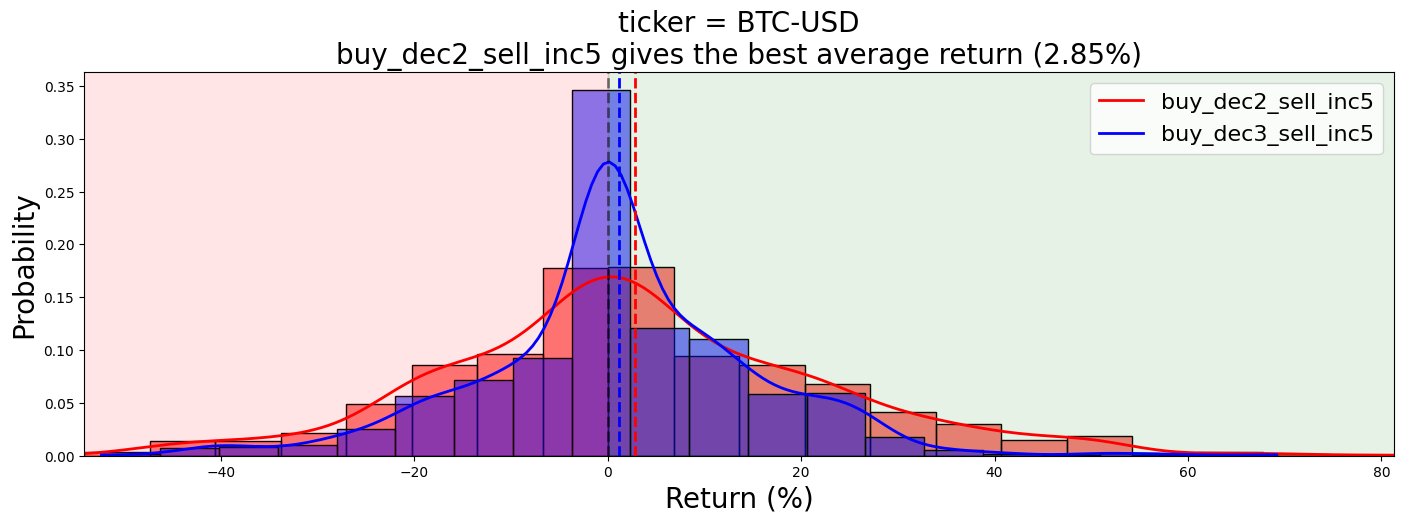

In [ ]:
legend = []
colors = ['r', 'b', 'g', 'k', 'orange', 'pink', 'gray', 'purple']
plt.figure(figsize=(14,5))

idx = 0
min_return = 1000000
max_return = -1000000
max_y = -1000000
conclusion = f'ticker = {symbol}\nNo strategy is expected to give positve return'
best_avg_return = 0

#plotting distributions of returns from each strategy
for name, returns in results.items():
    distr_plot = sns.histplot(returns, kde=True, line_kws={'linewidth': 2}, color=colors[idx], stat='probability', bins=20)
    max_y = max(max_y, distr_plot.get_ybound()[1])
    idx += 1
    legend.append(name)
    min_return = min(min_return, np.min(returns))
    max_return = max(max_return, np.max(returns))

    avg_return = np.mean(returns)
    if avg_return > best_avg_return:
        conclusion = f'ticker = {symbol}\n{name} gives the best average return ({round(avg_return,2)}%)'
        best_avg_return = avg_return
plt.legend(legend, fontsize=16)
plt.title(conclusion, fontsize=20)

idx = 0
plt.fill_betweenx([0,1], -100, 0, color='r', alpha=0.1)
plt.fill_betweenx([0,1], 0, 100, color='g', alpha=0.1)
plt.axvline(0, color='k', linestyle='--', linewidth=2, alpha=0.5)
for name, returns in results.items():
    plt.axvline(np.mean(returns), color=colors[idx], linestyle='--', linewidth=2)
    idx += 1

plt.xlim(min_return, max_return)
plt.ylim(0, max_y)

plt.tight_layout()
plt.xlabel('Return (%)', fontsize=20)
plt.ylabel('Probability', fontsize=20)

We can clearly see that we are expected to gain approximatelty 2.85% using the strategy of buying if the price decreases for 2 periods and selling if it increases for five periods over the course of a month but there is more risk involved as well.